## July Challenge: Image Classification


### Background

Machine learning can be used to classify images.  It can tell us: "This is a picture of a dog", "Picasso made this painting", that sort of thing.

### Challenge

I have prepared a collection of computer generated images in different styles (the styles are named after cities).  A bunch of the images have labels indicating their style.  Some of them are unlabelled.  We'd like you to figure out the correct labels for the unlabelled images.

The data, and more details, can be found at: https://www.kaggle.com/c/synthetic-image-classification/.  

That link goes to a Kaggle InClass competition I created.  Kaggle is a website for machine learning competitions.  The InClass competitions are academic competitions that don't affect your ranking.

### Criteria for Awesomeness

- Clean Code
- Evidence of TDD
- Score better than the benchmark on the competition leaderboard
- A go script and README (for people submitting solutions to be run locally)
- (Bonus) Evidence of data exploration (you can attach a pdf of a notebook, if you like)
- (Bonus) Analysis of how your algorithm works (activation maps, etc.)


In [ ]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

### Using EfficientNet 

Install `efficientnet` as pre-trained network, hopefully could get a better validation accurency.

- Github page is here(https://github.com/qubvel/efficientnet)
- Detail of the model (https://arxiv.org/abs/1905.11946)

In [ ]:
!pip install git+https://github.com/qubvel/efficientnet

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, RMSprop

from keras import layers as KL
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.losses import categorical_crossentropy
from efficientnet.keras import EfficientNetB3

from sklearn.preprocessing import LabelEncoder

Define some constants will be used along with the notebook

In [103]:
BATCH_SIZE=256

LABELS = ['Luanda', 'HongKong', 'Zurich', 'Singapore', 'Geneva',
          'Beijing', 'Seoul', 'Sydney', 'Melbourne', 'Brisbane']
EPOCHS=30

DATA_ROOT="../input/synimg/"

SPLIT_AT=80000

In [ ]:
styles_encoder = LabelEncoder().fit(LABELS)
print(styles_encoder.classes_)

### Playing around with the training data set

Just check how things look like in the data sets.

In [ ]:
def display_random_data(dataframe, rows):
    """
    Display some images from dataframe for demostration
    """
    imgs = dataframe.sample(rows *2)
    fig, axarr = plt.subplots(2, rows, figsize=(rows*10, rows*4))

    for i in range(1, rows*2+1):
        img_path = "../input/synimg/" + imgs.iloc[i-1]['filepath']
        img = image.load_img(img_path, target_size=(32, 64))
        img = image.img_to_array(img)/255
        axarr[i//(rows+1),i%rows].imshow(img)
        axarr[i//(rows+1),i%rows].set_title(imgs.iloc[i-1]['style_name'], fontsize=35)
        axarr[i//(rows+1),i%rows].axis('off')
        
display_random_data(df_train, 8)

### Split dataset as train and validation

In [110]:
def create_train_data_sets():
    """
    define the generator for loading training data sets
    """

    df_train = pd.read_csv("../input/synimg/synimg/train/data.csv")
    df_train = df_train.sample(frac=1.0)

    train_data=df_train[:SPLIT_AT]
    validation_data=df_train[SPLIT_AT:]

    data_gen = image.ImageDataGenerator(
        rescale=1./255.,
        rotation_range=15,
        horizontal_flip = True,
        zoom_range = 0.2,
        width_shift_range = 0.2,
        height_shift_range=0.2)
    
    validation_gen = image.ImageDataGenerator(rescale=1./255.)

    train_generator = data_gen.flow_from_dataframe(
        dataframe=train_data,
        directory="../input/synimg/",
        x_col="filepath",
        y_col="style_name",
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="categorical",
        target_size=(32, 64))

    validation_generator = validation_gen.flow_from_dataframe(
        dataframe=validation_data,
        directory="../input/synimg/",
        x_col="filepath",
        y_col="style_name",
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="categorical",
        target_size=(32, 64))

    return (train_generator, validation_generator)

### Build model with EfficientNetB3 and a simple full-connected-network

In [114]:
def build_model():
    input_shape = (32, 64, 3)

    # we don't need to train the pre-trained model
    efficient_net = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    efficient_net.trainable = False
    
    model = Sequential()
    model.add(efficient_net)
    model.add(KL.Flatten())
    model.add(KL.Dense(512, activation='relu'))
    model.add(KL.Dropout(0.5))
    model.add(KL.Dense(len(LABELS), activation='softmax'))
    
    model.summary()
    
    model.compile(optimizer=RMSprop(lr=0.0001, decay=1e-6),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

def build_model_o():
    input_shape = (32, 64, 3)
    
    efficient_net = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    efficient_net.trainable = False
    
    x = efficient_net.output
    x = KL.Flatten()(x)
    x = KL.Dense(512, activation="relu")(x)
    x = KL.Dropout(0.5)(x)
    predictions = KL.Dense(len(LABELS), activation="softmax")(x)
    
    model = Model(inputs = efficient_net.input, outputs = predictions)
    model.summary()
    
    model.compile(optimizer=RMSprop(lr=0.0001, decay=1e-6),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

### Train the model, save models regularly if any improvement made

Make sure we don't end up with something that totally not working, instead save the result model more often.

In [111]:
train_generator, validation_generator = create_train_data_sets()

steps_per_epoch_train = train_generator.n//train_generator.batch_size
steps_per_epoch_validation = validation_generator.n//validation_generator.batch_size


def training():
    model = build_model_o()

    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                                  verbose=1, mode='max', min_lr=0.000001)

    checkpoint = ModelCheckpoint("shokunin-july.h5", monitor='val_acc', verbose=1,
                                 save_best_only=True, mode='max')

    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=steps_per_epoch_train,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=steps_per_epoch_validation,
        callbacks=[checkpoint, reduce_lr])

    return history, model

Found 80000 validated image filenames belonging to 10 classes.
Found 20000 validated image filenames belonging to 10 classes.


### Wire them together now...

Do the actual training process...

In [ ]:
history, model = training()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 64, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 32, 40)   1080        input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 32, 40)   160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 16, 32, 40)   0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

Epoch 1/30


### Have a quick review of how everything goes

Check the accurency and loss in a line chart

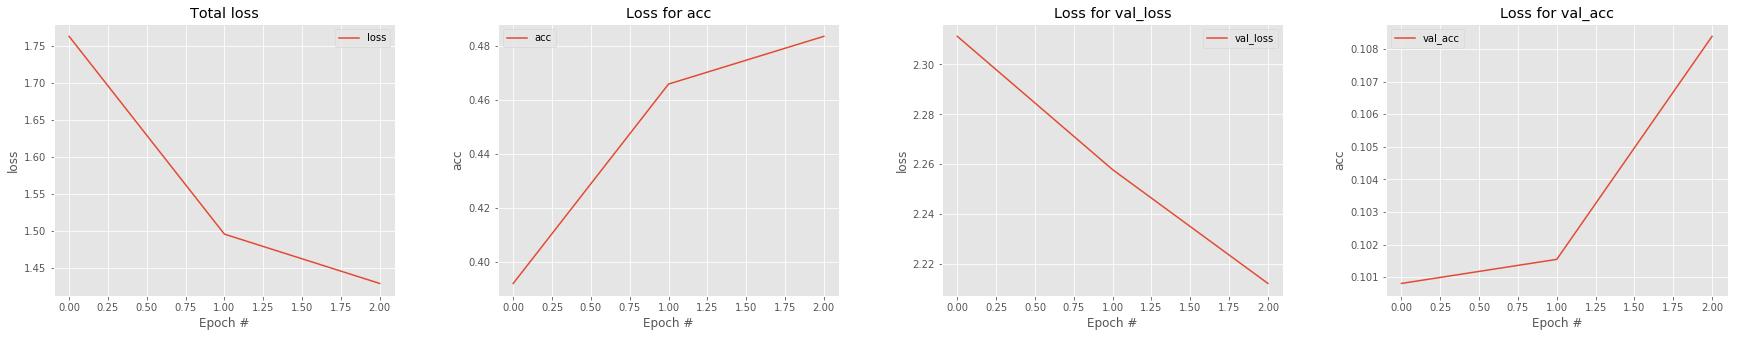

In [98]:
def analyse_results(epochs):
    metrics = ['loss', "acc", 'val_loss','val_acc']
        
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(1, 4, figsize=(30, 5))
    fig.subplots_adjust(hspace=0.1, wspace=0.3)

    for (i, l) in enumerate(metrics):
        title = "Loss for {}".format(l) if l != "loss" else "Total loss"
        ax[i].set_title(title)
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel(l.split('_')[-1])
        ax[i].plot(np.arange(0, epochs), history.history[l], label=l)
        ax[i].legend() 

analyse_results(EPOCHS)

### Predict

Now it's time to make sure the model works with new images never see before.

In [99]:
df_test = pd.read_csv("../input/synimg/synimg/test/data_nostyle.csv")

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory="../input/synimg/",
    x_col="filepath",
    target_size=(32, 64),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

test_generator.reset()

predications = model.predict_generator(test_generator, verbose=1, steps=312)

Found 20000 validated image filenames.
312/312 [==============================] - 53s 171ms/step


### Output

It took me a while to make it work with `styles_encoder` stuff, the results looked promising and the accurency was good, however the overall score is extramely low. I checked several times and eventually found that the label is in a alphabet order from `style_encoder` by default. The trick is the labels were in a different order in the `predications`.

Then I have to do it manually to correct the labeling:

```py
labeled = [{'label': styles_encoder.inverse_transform([index])[0], 'possibility': possibility} for (index, possibility) in
           enumerate(predication)]
```

After all the calculation, you may want to download files to local:

```py
from IPython.display import FileLink, FileLinks
FileLinks('.')
```

Execute the code above to get the downloadable links

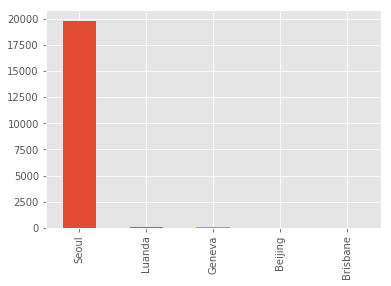

In [100]:
def style_of(predication):
    def possibility_of(item):
        return item.get('possibility')
    
    labeled = [{'label': styles_encoder.inverse_transform([index])[0], 'possibility': possibility} for (index, possibility) in
               enumerate(predication)]

    return max(labeled, key=possibility_of)

def summarize_prediction(predications):    
    labels = map(lambda x: style_of(x)['label'], predications)
    zipped = dict(zip(df_test.id, labels))
    
    return [{"id": k, "style_name": v} for k, v in zipped.items()]

submission = pd.DataFrame(summarize_prediction(predications))

submission.style_name.value_counts().plot.bar()
submission.to_csv("submission.csv",index=False)

In [101]:
submission.head()

,id,style_name
0,9000000,Seoul
1,9000001,Seoul
2,9000002,Seoul
3,9000003,Seoul
4,9000004,Seoul


In [102]:
from IPython.display import FileLink, FileLinks
FileLinks('.')

./
  __notebook_source__.ipynb
  submission-x.csv
  submission.csv
  shokunin-july.h5
  submission-y.csv
./.ipynb_checkpoints/
  __notebook_source__-checkpoint.ipynb